In [385]:
%load_ext autoreload
%autoreload 2

import os
BASE_DIR = os.path.abspath("..")
print("Base directory: {}".format(BASE_DIR))
import sys; sys.path.insert(0, BASE_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Base directory: /home/eric/projects/ds-project/code/src


In [386]:
import os
import multiprocessing
import warnings
import librosa
import utils
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm


warnings.filterwarnings('ignore')
dotenv_file = os.path.join(BASE_DIR, "../env/.env")
utils.loadenv(dotenv_file)

## Generating Features File [ skip ]

In [195]:
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()


def compute_features(tid):

    features = pd.Series(index=columns(), dtype=np.float32, name=tid)

    # Catch warnings as exceptions (audioread leaks file descriptors).
    warnings.filterwarnings('error', module='librosa')

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    try:
        filepath = utils.get_audio_path(os.environ.get('DIR_DATA'), tid)
        x, sr = librosa.load(filepath, sr=None, mono=True)  # kaiser_fast

        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
        feature_stats('zcr', f)

        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
        assert cqt.shape[0] == 7 * 12
        assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

        f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cqt', f)
        f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cens', f)
        f = librosa.feature.tonnetz(chroma=f)
        feature_stats('tonnetz', f)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        assert stft.shape[0] == 1 + 2048 // 2
        assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
        del x

        f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
        feature_stats('chroma_stft', f)

        f = librosa.feature.rmse(S=stft)
        feature_stats('rmse', f)

        f = librosa.feature.spectral_centroid(S=stft)
        feature_stats('spectral_centroid', f)
        f = librosa.feature.spectral_bandwidth(S=stft)
        feature_stats('spectral_bandwidth', f)
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
        feature_stats('spectral_contrast', f)
        f = librosa.feature.spectral_rolloff(S=stft)
        feature_stats('spectral_rolloff', f)

        mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
        feature_stats('mfcc', f)

    except Exception as e:
        print('{}: {}'.format(tid, repr(e)))

    return features

In [196]:
def save(features, ndigits):

    # Should be done already, just to be sure.
    features.sort_index(axis=0, inplace=True)
    features.sort_index(axis=1, inplace=True)

    features.to_csv('features.csv', float_format='%.{}e'.format(ndigits))


def test(features, ndigits):

    indices = features[features.isnull().any(axis=1)].index
    if len(indices) > 0:
        print('Failed tracks: {}'.format(', '.join(str(i) for i in indices)))

    tmp = utils.load('features.csv')
    np.testing.assert_allclose(tmp.values, features.values, rtol=10**-ndigits)


In [ ]:
tracks = utils.load(os.path.join(os.getenv("DIR_META"), 'tracks.csv'))
features = pd.DataFrame(index=tracks.index,
                        columns=columns(), dtype=np.float32)

# More than usable CPUs to be CPU bound, not I/O bound. Beware memory.
nb_workers = int(1.5 * len(os.sched_getaffinity(0)))

# Longest is ~11,000 seconds. Limit processes to avoid memory errors.
table = ((5000, 1), (3000, 3), (2000, 5), (1000, 10), (0, nb_workers))
for duration, nb_workers in table:
    print('Working with {} processes.'.format(nb_workers))

    tids = tracks[tracks['track', 'duration'] >= duration].index
    tracks.drop(tids, axis=0, inplace=True)

    pool = multiprocessing.Pool(nb_workers)
    it = pool.imap_unordered(compute_features, tids)

    for i, row in enumerate(tqdm(it, total=len(tids))):
        features.loc[row.name] = row

        if i % 1000 == 0:
            save(features, 10)

save(features, 10)
test(features, 10)


Working with 1 processes.


  0%|          | 0/6 [00:00<?, ?it/s]

2624: UserWarning('PySoundFile failed. Trying audioread instead.')
108001: UserWarning('PySoundFile failed. Trying audioread instead.')
112068: UserWarning('PySoundFile failed. Trying audioread instead.')
112880: UserWarning('PySoundFile failed. Trying audioread instead.')
122567: UserWarning('PySoundFile failed. Trying audioread instead.')
127430: UserWarning('PySoundFile failed. Trying audioread instead.')


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

Working with 3 processes.



  0%|          | 0/228 [00:00<?, ?it/s]

1564: UserWarning('PySoundFile failed. Trying audioread instead.')1563: UserWarning('PySoundFile failed. Trying audioread instead.')

3625: UserWarning('PySoundFile failed. Trying audioread instead.')
3712: UserWarning('PySoundFile failed. Trying audioread instead.')
3713: UserWarning('PySoundFile failed. Trying audioread instead.')3774: UserWarning('PySoundFile failed. Trying audioread instead.')

3864: UserWarning('PySoundFile failed. Trying audioread instead.')
3886: UserWarning('PySoundFile failed. Trying audioread instead.')4082: UserWarning('PySoundFile failed. Trying audioread instead.')

4399: UserWarning('PySoundFile failed. Trying audioread instead.')4240: UserWarning('PySoundFile failed. Trying audioread instead.')3903: UserWarning('PySoundFile failed. Trying audioread instead.')

4429: UserWarning('PySoundFile failed. Trying audioread instead.')

4514: UserWarning('PySoundFile failed. Trying audioread instead.')4455: UserWarning('PySoundFile failed. Trying audioread instead

100%|██████████| 228/228 [00:09<00:00, 23.39it/s]


Working with 5 processes.


  0%|          | 0/397 [00:00<?, ?it/s]

3540: UserWarning('PySoundFile failed. Trying audioread instead.')3703: UserWarning('PySoundFile failed. Trying audioread instead.')

3290: UserWarning('PySoundFile failed. Trying audioread instead.')1240: UserWarning('PySoundFile failed. Trying audioread instead.')3466: UserWarning('PySoundFile failed. Trying audioread instead.')
3729: UserWarning('PySoundFile failed. Trying audioread instead.')
3705: UserWarning('PySoundFile failed. Trying audioread instead.')



3809: UserWarning('PySoundFile failed. Trying audioread instead.')3876: UserWarning('PySoundFile failed. Trying audioread instead.')
4081: UserWarning('PySoundFile failed. Trying audioread instead.')3747: UserWarning('PySoundFile failed. Trying audioread instead.')


3866: UserWarning('PySoundFile failed. Trying audioread instead.')4162: UserWarning('PySoundFile failed. Trying audioread instead.')3902: UserWarning('PySoundFile failed. Trying audioread instead.')


4336: UserWarning('PySoundFile failed. Trying audioread inste

100%|██████████| 397/397 [00:10<00:00, 39.09it/s]


Working with 10 processes.


  0%|          | 0/1937 [00:00<?, ?it/s]

723: UserWarning('PySoundFile failed. Trying audioread instead.')396: UserWarning('PySoundFile failed. Trying audioread instead.')137: UserWarning('PySoundFile failed. Trying audioread instead.')
150: UserWarning('PySoundFile failed. Trying audioread instead.')
138: UserWarning('PySoundFile failed. Trying audioread instead.')422: UserWarning('PySoundFile failed. Trying audioread instead.')
847: UserWarning('PySoundFile failed. Trying audioread instead.')1110: UserWarning('PySoundFile failed. Trying audioread instead.')


1213: UserWarning('PySoundFile failed. Trying audioread instead.')
1113: UserWarning('PySoundFile failed. Trying audioread instead.')
1051: UserWarning('PySoundFile failed. Trying audioread instead.')1214: UserWarning('PySoundFile failed. Trying audioread instead.')

1218: UserWarning('PySoundFile failed. Trying audioread instead.')
1216: UserWarning('PySoundFile failed. Trying audioread instead.')

1355: UserWarning('PySoundFile failed. Trying audioread instead.')1380

100%|██████████| 1937/1937 [00:37<00:00, 51.05it/s] 


Working with 6 processes.


  0%|          | 0/104006 [00:00<?, ?it/s]

20: UserWarning('PySoundFile failed. Trying audioread instead.')26: UserWarning('PySoundFile failed. Trying audioread instead.')

3: UserWarning('PySoundFile failed. Trying audioread instead.')10: UserWarning('PySoundFile failed. Trying audioread instead.')2: UserWarning('PySoundFile failed. Trying audioread instead.')
30: UserWarning('PySoundFile failed. Trying audioread instead.')
5: UserWarning('PySoundFile failed. Trying audioread instead.')

48: UserWarning('PySoundFile failed. Trying audioread instead.')135: UserWarning('PySoundFile failed. Trying audioread instead.')

134: UserWarning('PySoundFile failed. Trying audioread instead.')
136: UserWarning('PySoundFile failed. Trying audioread instead.')

46: UserWarning('PySoundFile failed. Trying audioread instead.')140: UserWarning('PySoundFile failed. Trying audioread instead.')
139: UserWarning('PySoundFile failed. Trying audioread instead.')
142: UserWarning('PySoundFile failed. Trying audioread instead.')
141: UserWarning('PySou

## Baseline

In [387]:
import os
import utils
import warnings
import numpy as np

warnings.filterwarnings('ignore')

AUDIO_DIR = os.environ.get('DIR_DATA')
META_DIR = os.environ.get('DIR_META')

tracks = utils.load(os.path.join(META_DIR, 'tracks.csv'))
features = utils.load(os.path.join(META_DIR, 'features.csv'))
echonest = utils.load(os.path.join(META_DIR, 'echonest.csv'))

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

### Subset split

In [388]:
# subset = tracks.index[tracks['set', 'subset'] <= 'medium']
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [390]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('\nTop genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('\nAll genres ({}): {}'.format(len(genres), genres))

6400 training examples, 800 validation examples, 800 testing examples

Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

All genres (114): [1, 2, 6, 10, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 38, 41, 42, 45, 46, 47, 49, 53, 58, 64, 66, 70, 71, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 167, 171, 172, 174, 177, 180, 181, 182, 183, 184, 185, 186, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 314, 337, 359, 360, 361, 362, 400, 401, 404, 439, 440, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 695, 741, 763, 808, 811, 1032, 1060, 1193, 1235]


In [391]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler

def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
        #y = enc.fit_transform(tracks['track', 'genre_top'])
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    x_train = features.loc[train, columns].to_numpy()
    x_val = features.loc[val, columns].to_numpy()
    x_test = features.loc[test, columns].to_numpy()
    
    x_train, y_train = shuffle(x_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(x_train)
    scaler.transform(x_val)
    scaler.transform(x_test)
    
    return y_train, y_val, y_test, x_train, x_val, x_test


In [392]:
from tqdm.notebook import tqdm
import sklearn.metrics
import pandas as pd
import datetime
import pickle
import time


OUT_DIR = "./outputs/"
MODEL_DIR = os.path.join(OUT_DIR, "models")


def save_model(model, filepath):
    dname = os.path.dirname(filepath)
    os.makedirs(dname, exists_ok=True)
    with open(filepath, 'wb') as fp:
        pickle.dump(model, fp)
        
    
def load_model(filepath):
    print(filepath)
    with open(filepath, 'rb') as fp:
        model = pickle.load(fp)
    return model


def test_classifiers_features(classifiers, feature_sets, exec_id=None, multi_label=False, reuse_exec=None):
    """
    Args;
        classifiers (dict): mapping of classifier names to their y
    """

    columns = list(classifiers.keys()).insert(0, 'dim')
    
    print("\tLengths:\tclassifiers: {}\tfeature sets: {}".format(len(classifiers), len(feature_sets)))
    print("Classifiers: {}\tFeature Sets: {}".format(classifiers, feature_sets))
    
    if exec_id is None: exec_id = str(datetime.datetime.utcnow().isoformat())
    execution_path = os.path.join(MODEL_DIR, exec_id)
    os.makedirs(execution_path, exist_ok=True)
    
    # path for reloading models from disk
    reuse_path = None if reuse_exec is None else os.path.join(MODEL_DIR, reuse_exec)
    
    mean_accuracies = pd.DataFrame(columns=columns, index=feature_sets.keys())
    precisions = pd.DataFrame(columns=columns, index=feature_sets.keys())
    recalls = pd.DataFrame(columns=columns, index=feature_sets.keys())
    f1_measures = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())

    for fset_name, fset in tqdm(feature_sets.items(), desc='Feature sets'):
        
        print("Retrieving classifiers for set: {}".format(fset_name))
        y_train_true, y_val_true, _, x_train, x_val, _ = pre_process(tracks, features_all, fset, multi_label)
        
        mean_accuracies.loc[fset_name, 'dim'] = x_train.shape[1]
        precisions.loc[fset_name, 'dim'] = x_train.shape[1]
        recalls.loc[fset_name, 'dim'] = x_train.shape[1]
        f1_measures.loc[fset_name, 'dim'] = x_train.shape[1]

        for clf_name, clf in tqdm(classifiers.items(), desc='Classifiers', leave=False):
            
            model_filename = "{}_{}.pkl".format(clf_name, fset_name)
            if reuse_path:
                model_path = os.path.join(reuse_path, model_filename)
                if os.path.exists(model_path):
                    print("Reloading model from disk: {}".format(model_filename))
                    clf = load_model(model_path)
            else:
                print("Training model from scratch: {}".format(clf_name))
                
                # train model
                t = time.process_time()
                clf.fit(x_train, y_train_true)
                times.loc[fset_name, clf_name] = time.process_time() - t
                
                # save model to disk
                try:
                    filepath = os.path.join(execution_path, model_filename)
                    save_model(model=clf, filepath=filepath)
                except Exception as err:
                    print("Failed to save model {} on disk: {}".format(clf_name, err))
            
            # run prediction on validation set
            y_val_pred = clf.predict(x_val)
            
            assert y_val_true.shape == y_val_pred.shape, "Shapes of y_val for GT and PREDICTION don't match."

            # get metrics
            mean_acc = clf.score(x_val, y_val_true)
            #accuracy = accuracy_score(y_val_true, y_val_pred)
            
            precision = sklearn.metrics.precision_score(y_val_true, y_val_pred, average='macro')
            recall = sklearn.metrics.recall_score(y_val_true, y_val_pred, average='macro')
            f1 = sklearn.metrics.f1_score(y_val_true, y_val_pred, average='macro')
            
            # print("{}\t{}\t{}\t{}".format(mean_acc, precision, recall, f1))
            
            # update dataframes
            mean_accuracies.loc[fset_name, clf_name] = mean_acc
            precisions.loc[fset_name, clf_name] = precision
            recalls.loc[fset_name, clf_name] = recall
            f1_measures.loc[fset_name, clf_name] = f1

            # ROC AUC
            # auc = sklearn.metrics.roc_auc_score(y_val_true, y_val_pred_probs)
            # print('ROC AUC: %f' % auc)
            
            # confusion matrix
            # matrix = sklearn.metrics.confusion_matrix(y_val_true, y_val_pred)
            # print(matrix)

    metrics = {
        'acc': mean_accuracies,
        'precision': precisions,
        'recall': recalls,
        'f1': f1_measures,
    }
            
    return metrics, times


In [393]:
import os

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.multiclass import OneVsRestClassifier


classifiers = {
    'LR':       LogisticRegression(),
    'kNN':      KNeighborsClassifier(n_neighbors=200),
    'SVCrbf':   SVC(kernel='rbf'),
    'SVCpoly1': SVC(kernel='poly', degree=1),
    'linSVC1':  SVC(kernel="linear"),
    'linSVC2':  LinearSVC(),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    'DT':       DecisionTreeClassifier(max_depth=5),
    'RF':       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=10),
    'MLP1':     MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
    'MLP2':     MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    'NB':       GaussianNB(),
    'QDA':      QuadraticDiscriminantAnalysis(),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_social': ('echonest', 'social_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
#    'echonest_audio/social': ('echonest', ('audio_features', 'social_features')),
#    'echonest_all': ('echonest', ('audio_features', 'social_features', 'temporal_features')),
}
feature_sets.update({
    'mfcc+contrast': ['mfcc', 'spectral_contrast'],
    'mfcc+contrast+chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
    'mfcc+contrast+centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
    'mfcc+contrast+chroma+centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
    'mfcc+contrast+chroma+centroid+tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc+contrast+chroma+centroid+zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})
# for name in features.columns.levels[0]:
#     feature_sets[name] = name

RETRAIN = True
if RETRAIN:
    reuse_exec = "clf_baseline"
    metrics, times = test_classifiers_features(classifiers, feature_sets, reuse_exec=reuse_exec)


	Lengths:	classifiers: 13	feature sets: 7
Classifiers: {'LR': LogisticRegression(), 'kNN': KNeighborsClassifier(n_neighbors=200), 'SVCrbf': SVC(), 'SVCpoly1': SVC(degree=1, kernel='poly'), 'linSVC1': SVC(kernel='linear'), 'linSVC2': LinearSVC(), 'DT': DecisionTreeClassifier(max_depth=5), 'RF': RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10), 'AdaBoost': AdaBoostClassifier(n_estimators=10), 'MLP1': MLPClassifier(max_iter=2000), 'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000), 'NB': GaussianNB(), 'QDA': QuadraticDiscriminantAnalysis()}	Feature Sets: {'mfcc+contrast': ['mfcc', 'spectral_contrast'], 'mfcc+contrast+chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'], 'mfcc+contrast+centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'], 'mfcc+contrast+chroma+centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'], 'mfcc+contrast+chroma+centroid+tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 't

Retrieving classifiers for set: mfcc+contrast


Reloading model from disk: LR_mfcc+contrast.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast.pkl
Reloading model from disk: kNN_mfcc+contrast.pkl
./outputs/models/clf_baseline/kNN_mfcc+contrast.pkl
Reloading model from disk: SVCrbf_mfcc+contrast.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast.pkl
Reloading model from disk: SVCpoly1_mfcc+contrast.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast.pkl
Reloading model from disk: linSVC1_mfcc+contrast.pkl
./outputs/models/clf_baseline/linSVC1_mfcc+contrast.pkl
Reloading model from disk: linSVC2_mfcc+contrast.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast.pkl
Reloading model from disk: DT_mfcc+contrast.pkl
./outputs/models/clf_baseline/DT_mfcc+contrast.pkl
Reloading model from disk: RF_mfcc+contrast.pkl
./outputs/models/clf_baseline/RF_mfcc+contrast.pkl
Reloading model from disk: AdaBoost_mfcc+contrast.pkl
./outputs/models/clf_baseline/AdaBoost_mfcc+contrast.pkl
Reloading model from disk: MLP1_mfcc+contrast.pkl
./out

Reloading model from disk: LR_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast+chroma.pkl
Reloading model from disk: kNN_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/kNN_mfcc+contrast+chroma.pkl
Reloading model from disk: SVCrbf_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast+chroma.pkl
Reloading model from disk: SVCpoly1_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast+chroma.pkl
Reloading model from disk: linSVC1_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/linSVC1_mfcc+contrast+chroma.pkl
Reloading model from disk: linSVC2_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast+chroma.pkl
Reloading model from disk: DT_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/DT_mfcc+contrast+chroma.pkl
Reloading model from disk: RF_mfcc+contrast+chroma.pkl
./outputs/models/clf_baseline/RF_mfcc+contrast+chroma.pkl
Reloading model from disk: AdaBoost_mfcc+contrast+chro

Reloading model from disk: LR_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast+centroid.pkl
Reloading model from disk: kNN_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/kNN_mfcc+contrast+centroid.pkl
Reloading model from disk: SVCrbf_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast+centroid.pkl
Reloading model from disk: SVCpoly1_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast+centroid.pkl
Reloading model from disk: linSVC1_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/linSVC1_mfcc+contrast+centroid.pkl
Reloading model from disk: linSVC2_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast+centroid.pkl
Reloading model from disk: DT_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/DT_mfcc+contrast+centroid.pkl
Reloading model from disk: RF_mfcc+contrast+centroid.pkl
./outputs/models/clf_baseline/RF_mfcc+contrast+centroid.pkl
Reloading model from d

Reloading model from disk: LR_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: kNN_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/kNN_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: SVCrbf_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: SVCpoly1_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: linSVC1_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/linSVC1_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: linSVC2_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: DT_mfcc+contrast+chroma+centroid.pkl
./outputs/models/clf_baseline/DT_mfcc+contrast+chroma+centroid.pkl
Reloading model from disk: RF_mfcc+contra

Reloading model from disk: LR_mfcc+contrast+chroma+centroid+tonnetz.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast+chroma+centroid+tonnetz.pkl
Reloading model from disk: kNN_mfcc+contrast+chroma+centroid+tonnetz.pkl
./outputs/models/clf_baseline/kNN_mfcc+contrast+chroma+centroid+tonnetz.pkl
Reloading model from disk: SVCrbf_mfcc+contrast+chroma+centroid+tonnetz.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast+chroma+centroid+tonnetz.pkl
Reloading model from disk: SVCpoly1_mfcc+contrast+chroma+centroid+tonnetz.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast+chroma+centroid+tonnetz.pkl
Reloading model from disk: linSVC1_mfcc+contrast+chroma+centroid+tonnetz.pkl
./outputs/models/clf_baseline/linSVC1_mfcc+contrast+chroma+centroid+tonnetz.pkl
Reloading model from disk: linSVC2_mfcc+contrast+chroma+centroid+tonnetz.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast+chroma+centroid+tonnetz.pkl
Reloading model from disk: DT_mfcc+contrast+chroma+centroid+tonnetz.pkl
./ou

Reloading model from disk: LR_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast+chroma+centroid+zcr.pkl
Reloading model from disk: kNN_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/kNN_mfcc+contrast+chroma+centroid+zcr.pkl
Reloading model from disk: SVCrbf_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast+chroma+centroid+zcr.pkl
Reloading model from disk: SVCpoly1_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast+chroma+centroid+zcr.pkl
Reloading model from disk: linSVC1_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/linSVC1_mfcc+contrast+chroma+centroid+zcr.pkl
Reloading model from disk: linSVC2_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast+chroma+centroid+zcr.pkl
Reloading model from disk: DT_mfcc+contrast+chroma+centroid+zcr.pkl
./outputs/models/clf_baseline/DT_mfcc+contrast+chroma+ce

Reloading model from disk: LR_all_non-echonest.pkl
./outputs/models/clf_baseline/LR_all_non-echonest.pkl
Reloading model from disk: kNN_all_non-echonest.pkl
./outputs/models/clf_baseline/kNN_all_non-echonest.pkl
Reloading model from disk: SVCrbf_all_non-echonest.pkl
./outputs/models/clf_baseline/SVCrbf_all_non-echonest.pkl
Reloading model from disk: SVCpoly1_all_non-echonest.pkl
./outputs/models/clf_baseline/SVCpoly1_all_non-echonest.pkl
Reloading model from disk: linSVC1_all_non-echonest.pkl
./outputs/models/clf_baseline/linSVC1_all_non-echonest.pkl
Reloading model from disk: linSVC2_all_non-echonest.pkl
./outputs/models/clf_baseline/linSVC2_all_non-echonest.pkl
Reloading model from disk: DT_all_non-echonest.pkl
./outputs/models/clf_baseline/DT_all_non-echonest.pkl
Reloading model from disk: RF_all_non-echonest.pkl
./outputs/models/clf_baseline/RF_all_non-echonest.pkl
Reloading model from disk: AdaBoost_all_non-echonest.pkl
./outputs/models/clf_baseline/AdaBoost_all_non-echonest.pkl
R

In [394]:
import pickle
import datetime

OUT_DIR = "outputs/"
unique_name = str(datetime.datetime.utcnow().isoformat()) + ".bin"

os.makedirs(OUT_DIR, exist_ok=True)
with open(os.path.join(OUT_DIR, unique_name), 'wb') as fp:
    pickle.dump(metrics, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [395]:
import IPython.display as ipd


def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        is_min = s == min(s[1:])
        max_highlight = ['background-color: green' if v else '' for v in is_max]
        min_highlight = ['background-color: orange' if v else '' for v in is_min]
        zipped = [ ";".join([a, b]) for a, b in zip(max_highlight, min_highlight) ]
        return zipped
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])


for key, m in metrics.items():

    ipd.display("{}:".format(key))
    ipd.display(format_scores(m))

# ipd.display("times:")
# ipd.display(times.style.format('{:.4f}'))


'acc:'

,dim,LR,kNN,SVCrbf,SVCpoly1,linSVC1,linSVC2,DT,RF,AdaBoost,MLP1,MLP2,NB,QDA
mfcc+contrast,189.000000,52.75%,45.38%,56.00%,55.38%,51.75%,52.88%,39.00%,44.50%,43.00%,48.25%,47.75%,48.25%,46.88%
mfcc+contrast+chroma,273.000000,52.00%,43.12%,55.25%,54.37%,51.25%,51.75%,39.12%,36.75%,45.12%,46.00%,51.00%,46.62%,44.88%
mfcc+contrast+centroid,196.000000,51.62%,46.25%,55.00%,55.75%,51.12%,51.62%,41.62%,42.75%,39.75%,46.12%,50.12%,48.38%,47.25%
mfcc+contrast+chroma+centroid,280.000000,50.88%,43.62%,55.38%,54.12%,49.25%,50.62%,42.00%,41.25%,39.00%,50.25%,46.12%,46.75%,46.38%
mfcc+contrast+chroma+centroid+tonnetz,322.000000,51.38%,41.25%,55.50%,53.25%,49.62%,51.00%,42.50%,39.00%,39.12%,48.62%,50.88%,46.50%,43.25%
mfcc+contrast+chroma+centroid+zcr,287.000000,50.88%,44.25%,54.62%,53.75%,48.00%,50.50%,41.88%,43.12%,39.00%,50.38%,52.12%,46.75%,44.88%
all_non-echonest,518.000000,50.75%,40.38%,55.75%,53.62%,47.75%,51.50%,40.75%,41.12%,37.38%,53.12%,54.12%,34.88%,36.38%


'precision:'

,dim,LR,kNN,SVCrbf,SVCpoly1,linSVC1,linSVC2,DT,RF,AdaBoost,MLP1,MLP2,NB,QDA
mfcc+contrast,189.000000,51.67%,48.06%,54.74%,53.83%,51.68%,50.67%,38.20%,42.74%,44.74%,48.29%,47.27%,46.57%,47.87%
mfcc+contrast+chroma,273.000000,50.81%,48.51%,54.84%,53.19%,51.19%,50.09%,38.41%,34.44%,43.57%,45.80%,49.69%,44.87%,47.54%
mfcc+contrast+centroid,196.000000,50.46%,49.01%,53.55%,54.29%,50.98%,49.25%,42.34%,39.95%,36.61%,46.98%,49.94%,46.56%,47.91%
mfcc+contrast+chroma+centroid,280.000000,50.09%,50.48%,54.71%,52.96%,49.38%,48.58%,43.27%,39.36%,34.68%,50.40%,45.74%,45.01%,49.13%
mfcc+contrast+chroma+centroid+tonnetz,322.000000,50.59%,47.75%,54.57%,52.00%,49.10%,49.16%,42.64%,35.67%,37.26%,47.75%,49.55%,44.30%,47.11%
mfcc+contrast+chroma+centroid+zcr,287.000000,49.89%,51.97%,53.75%,52.38%,48.67%,48.16%,43.46%,41.56%,34.68%,49.81%,51.82%,45.36%,47.40%
all_non-echonest,518.000000,49.80%,47.57%,54.53%,52.58%,48.71%,50.05%,41.71%,38.94%,33.98%,52.95%,53.69%,45.38%,37.17%


'recall:'

,dim,LR,kNN,SVCrbf,SVCpoly1,linSVC1,linSVC2,DT,RF,AdaBoost,MLP1,MLP2,NB,QDA
mfcc+contrast,189.000000,52.75%,45.38%,56.00%,55.38%,51.75%,52.88%,39.00%,44.50%,43.00%,48.25%,47.75%,48.25%,46.88%
mfcc+contrast+chroma,273.000000,52.00%,43.12%,55.25%,54.37%,51.25%,51.75%,39.12%,36.75%,45.12%,46.00%,51.00%,46.62%,44.88%
mfcc+contrast+centroid,196.000000,51.62%,46.25%,55.00%,55.75%,51.12%,51.62%,41.62%,42.75%,39.75%,46.12%,50.12%,48.37%,47.25%
mfcc+contrast+chroma+centroid,280.000000,50.88%,43.62%,55.38%,54.12%,49.25%,50.62%,42.00%,41.25%,39.00%,50.25%,46.13%,46.75%,46.38%
mfcc+contrast+chroma+centroid+tonnetz,322.000000,51.37%,41.25%,55.50%,53.25%,49.62%,51.00%,42.50%,39.00%,39.12%,48.62%,50.88%,46.50%,43.25%
mfcc+contrast+chroma+centroid+zcr,287.000000,50.88%,44.25%,54.62%,53.75%,48.00%,50.50%,41.88%,43.12%,39.00%,50.38%,52.12%,46.75%,44.88%
all_non-echonest,518.000000,50.75%,40.38%,55.75%,53.62%,47.75%,51.50%,40.75%,41.12%,37.38%,53.12%,54.12%,34.88%,36.38%


'f1:'

,dim,LR,kNN,SVCrbf,SVCpoly1,linSVC1,linSVC2,DT,RF,AdaBoost,MLP1,MLP2,NB,QDA
mfcc+contrast,189.000000,51.83%,40.35%,54.76%,54.25%,51.28%,51.17%,37.56%,40.04%,39.97%,48.00%,47.36%,45.75%,46.61%
mfcc+contrast+chroma,273.000000,51.12%,39.06%,54.40%,53.39%,50.82%,50.57%,37.66%,33.37%,42.49%,45.73%,49.99%,44.65%,44.90%
mfcc+contrast+centroid,196.000000,50.76%,41.23%,53.65%,54.62%,50.59%,49.98%,40.74%,39.71%,36.72%,46.26%,49.58%,45.78%,46.52%
mfcc+contrast+chroma+centroid,280.000000,50.24%,39.97%,54.33%,53.17%,48.85%,49.22%,41.12%,38.57%,36.04%,49.93%,45.77%,44.72%,46.36%
mfcc+contrast+chroma+centroid+tonnetz,322.000000,50.80%,37.02%,54.34%,52.20%,48.76%,49.71%,41.28%,35.91%,36.00%,47.89%,49.89%,44.54%,43.37%
mfcc+contrast+chroma+centroid+zcr,287.000000,50.11%,40.18%,53.42%,52.64%,47.77%,48.87%,41.04%,40.77%,36.04%,49.60%,51.79%,44.81%,44.82%
all_non-echonest,518.000000,49.91%,33.87%,54.38%,52.58%,47.49%,50.30%,39.26%,38.76%,34.63%,52.72%,53.68%,31.65%,34.98%


## Using 'mfcc+contrast' with top 5 clf (gathering their prediction results)

### Reloading Classifiers for Ensemble One

In [398]:
fset_name = 'mfcc+contrast'
fset = feature_sets['mfcc+contrast']
estimator1 = list()

top_5_clf = {
    'linSVC1':  SVC(kernel="linear"),
    'linSVC2':  LinearSVC(),
    'LR':       LogisticRegression(),
    'SVCpoly1': SVC(kernel='poly', degree=1),
    'SVCrbf':   SVC(kernel='rbf'),
}


top_5_pred_test1 = []

multi_label = False
reuse_path = None if reuse_exec is None else os.path.join(MODEL_DIR, reuse_exec)

y_train_true, y_val_true, y_test_true, x_train, x_val, x_test = pre_process(tracks, features_all, fset, multi_label)

for clf_name, clf in tqdm(top_5_clf.items(), desc='Classifiers', leave=False):
    
    model_filename = "{}_{}.pkl".format(clf_name, fset_name)
    if reuse_path:
        model_path = os.path.join(reuse_path, model_filename)
        if os.path.exists(model_path):
            #print("Reloading model from disk: {}".format(model_filename))
            clf = load_model(model_path)
    else:
        print("Training model from scratch: {}".format(clf_name))
        
        # train model
        t = time.process_time()
        clf.fit(x_train, y_train_true)
        times.loc[fset_name, clf_name] = time.process_time() - t
        
        # save model to disk
        try:
            filepath = os.path.join(execution_path, model_filename)
            save_model(model=clf, filepath=filepath)
        except Exception as err:
            print("Failed to save model {} on disk: {}".format(clf_name, err))

    # run prediction on validation set
    y_test_pred = clf.predict(x_test)
    #print("{}'s prediction is {}:".format(clf_name, y_val_pred))
    top_5_pred_test1.append(y_test_pred)
    assert y_test_true.shape == y_test_pred.shape, "Shapes of y_val for GT and PREDICTION don't match."

    # for eclf estimators
    estimator1.append((clf_name, clf))

./outputs/models/clf_baseline/linSVC1_mfcc+contrast.pkl
./outputs/models/clf_baseline/linSVC2_mfcc+contrast.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast.pkl
./outputs/models/clf_baseline/SVCpoly1_mfcc+contrast.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast.pkl


### Reloading Classifiers for Ensemble Two

In [399]:
fset_name = 'mfcc+contrast'
fset = feature_sets['mfcc+contrast']

estimator2 = list()
E2 = {
    'MLP2':     MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    'LR':       LogisticRegression(),
    'SVCrbf':   SVC(kernel='rbf')
}


top_5_pred_test2 = []

multi_label = False
reuse_path = None if reuse_exec is None else os.path.join(MODEL_DIR, reuse_exec)

y_train_true, y_val_true, y_test_true, x_train, x_val, x_test = pre_process(tracks, features_all, fset, multi_label)

for clf_name, clf in tqdm(E2.items(), desc='Classifiers', leave=False):
    
    model_filename = "{}_{}.pkl".format(clf_name, fset_name)
    if reuse_path:
        model_path = os.path.join(reuse_path, model_filename)
        if os.path.exists(model_path):
            #print("Reloading model from disk: {}".format(model_filename))
            clf = load_model(model_path)
    else:
        print("Training model from scratch: {}".format(clf_name))
        
        # train model
        t = time.process_time()
        clf.fit(x_train, y_train_true)
        times.loc[fset_name, clf_name] = time.process_time() - t
        
        # save model to disk
        try:
            filepath = os.path.join(execution_path, model_filename)
            save_model(model=clf, filepath=filepath)
        except Exception as err:
            print("Failed to save model {} on disk: {}".format(clf_name, err))

    # run prediction on validation set
    y_test_pred = clf.predict(x_test)
    #print("{}'s prediction is {}:".format(clf_name, y_val_pred))
    top_5_pred_test2.append(y_test_pred)
    assert y_test_true.shape == y_test_pred.shape, "Shapes of y_val for GT and PREDICTION don't match."

    # for eclf estimators
    estimator2.append((clf_name, clf))

./outputs/models/clf_baseline/MLP2_mfcc+contrast.pkl
./outputs/models/clf_baseline/LR_mfcc+contrast.pkl
./outputs/models/clf_baseline/SVCrbf_mfcc+contrast.pkl


## Kfold for Individual Top-5 Classifiers and Ensemble Classifier with Accuracy and F1

### Kfold Ensemble One Performance

In [110]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, cross_val_score

ensemble1_clf = {'eclf': VotingClassifier(estimators=estimator1, voting='hard')}
top_5_clf.update(ensemble1_clf)

scores = []
f1_list = []
names = []

# kfold
seed = 1

for clf_name, clf in tqdm(top_5_clf.items(), desc='Classifiers', leave=False):
    kfold = KFold(n_splits=5, random_state=seed)
    score = cross_val_score(clf, x_train, y_train_true, cv=kfold, scoring='accuracy')
    f1    = cross_val_score(clf, x_train, y_train_true, cv=kfold, scoring='f1_macro')

    names.append(clf_name)
    scores.append(score.mean())
    f1_list.append(f1.mean())

In [121]:
for i in range(len(names)):
    print("{:>8} Accuracy: {:0.4f} F1: {:0.4f}".format(names[i], scores[i], f1_list[i]))

 linSVC1 Accuracy: 0.5306 F1: 0.5285
 linSVC2 Accuracy: 0.5425 F1: 0.5317
      LR Accuracy: 0.5398 F1: 0.5361
SVCpoly1 Accuracy: 0.5552 F1: 0.5490
  SVCrbf Accuracy: 0.5986 F1: 0.5972
    eclf Accuracy: 0.5667 F1: 0.5600


### Kfold Ensemble Two Performance

In [240]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, cross_val_score

ensemble_clf2 = {'eclf2': VotingClassifier(estimators=estimator2, voting='hard')}
E2.update(ensemble_clf2)

scores = []
f1_list = []
names = []

# kfold
seed = 1

for clf_name, clf in tqdm(E2.items(), desc='Classifiers', leave=False):
    kfold = KFold(n_splits=5, random_state=seed)
    score = cross_val_score(clf, x_train, y_train_true, cv=kfold, scoring='accuracy')
    f1    = cross_val_score(clf, x_train, y_train_true, cv=kfold, scoring='f1_macro')

    names.append(clf_name)
    scores.append(score.mean())
    f1_list.append(f1.mean())

In [241]:
for i in range(len(names)):
    print("{:>8} Accuracy: {:0.4f} F1: {:0.4f}".format(names[i], scores[i], f1_list[i]))

    MLP2 Accuracy: 0.5723 F1: 0.5616
      LR Accuracy: 0.5398 F1: 0.5361
  SVCrbf Accuracy: 0.5986 F1: 0.5972
   eclf2 Accuracy: 0.5964 F1: 0.5930


## Ensemble voting(hardcoding)

In [122]:
def ensemble_pred(top_5_pred):
    def agreement(current_list):
        agreement=list()
        temp_dict = {} 
        for item in current_list: 
            if (item in temp_dict): 
                temp_dict[item] += 1
            else: 
                temp_dict[item] = 1

        for key in temp_dict:
            if temp_dict[key] >= max(temp_dict.values()):
                agreement=key
        return agreement
    
    final_pred = list()
    for i in range(len(top_5_pred[0])):
        current_list = (top_5_pred[0][i], top_5_pred[1][i], top_5_pred[2][i], top_5_pred[3][i], top_5_pred[4][i])
        final_pred.append((agreement(current_list)))
    
    return final_pred


## Ensemble One Performance Evaluation on Test Data

### Using Hardcoded Ensemble Methond Result with Test Data on Ensemble One

In [126]:
from sklearn.metrics import accuracy_score

final_pred_test = ensemble_pred(top_5_pred_test)

accuracy_test = accuracy_score(y_test_true, final_pred_test)
f1_top5clf_test = sklearn.metrics.f1_score(y_test_true, final_pred_test, average='macro')
precision_top5clf_test = sklearn.metrics.precision_score(y_test_true, final_pred_test, average='macro')
recall_top5clf_test = sklearn.metrics.recall_score(y_test_true, final_pred_test, average='macro')

print("Performance of the ensemble clf using test data\n")

print('{:>10} : {:.4f}\n {:>9} : {:.4f}\n {:>9} : {:.4f}\n {:>9} : {:.4f}\n'.format('accuracy', accuracy_test,
                                                                                    'f1', f1_top5clf_test,
                                                                                    'precision',precision_top5clf_test,
                                                                                    'recall',recall_top5clf_test))

Performance of the ensemble clf using test data

  accuracy : 0.4600
        f1 : 0.4568
 precision : 0.4554
    recall : 0.4600



### Using Sklearn Ensemble Methond Result with Test Data on Ensemble One

In [402]:
eclf1 = VotingClassifier(estimators=estimator1, voting='hard')

eclf1.fit(x_train, y_train_true)
eclf1_test_pred = eclf1.predict(x_test)

accuracy_test = accuracy_score(y_test_true, eclf_test_pred)
f1_top5clf_test = sklearn.metrics.f1_score(y_test_true, eclf1_test_pred, average='macro')
precision_top5clf_test = sklearn.metrics.precision_score(y_test_true, eclf1_test_pred, average='macro')
recall_top5clf_test = sklearn.metrics.recall_score(y_test_true, eclf1_test_pred, average='macro')

print("Performance of the ensemble clf using test data\n")
print('{:>10} : {:.4f}\n {:>9} : {:.4f}\n {:>9} : {:.4f}\n {:>9} : {:.4f}\n'.format('accuracy', accuracy_test,
                                                                                    'f1', f1_top5clf_test,
                                                                                    'precision',precision_top5clf_test,
                                                                                    'recall',recall_top5clf_test))

Performance of the ensemble clf using test data

  accuracy : 0.4537
        f1 : 0.4545
 precision : 0.4545
    recall : 0.4575



### Using Sklearn Ensemble Methond Result with Test Data on Ensemble Two

In [382]:
eclf2 = VotingClassifier(estimators=estimator2, voting='hard')
eclf2.fit(x_train, y_train_true)
eclf2_test_pred = eclf2.predict(x_test)


f1_eclf2_test = sklearn.metrics.f1_score(y_test_true, eclf2_test_pred, average='macro')
print('Ensemble Two F1 Performance : {:.4f}'.format(f1_eclf2_test))

Ensemble Two F1 Performance : 0.4648


### F1 Performance on Test Data with Each Individual and Ensemble One Classifier

In [403]:
from sklearn.metrics import accuracy_score
sum_f1 = 0
print("F1 Performance of the clf using test data\n")
for clf_name, clf in estimator:
    y_test_pred = clf.predict(x_test)

    # accuracy_test = accuracy_score(y_test_true, y_test_pred)
    f1 = sklearn.metrics.f1_score(y_test_true, y_test_pred, average='macro')
    # precision_top5clf_test = sklearn.metrics.precision_score(y_test_true, y_test_pred, average='macro')
    # recall_top5clf_test = sklearn.metrics.recall_score(y_test_true, y_test_pred, average='macro')
    sum_f1 = sum_f1 + f1
    print('{:>10} : {:.4f}'.format(clf_name, f1))
print('{:>10} : {:.4f}'.format('Eclf1',f1_top5clf_test))

F1 Performance of the clf using test data

   linSVC1 : 0.4303
   linSVC2 : 0.4247
        LR : 0.4309
  SVCpoly1 : 0.4498
    SVCrbf : 0.4764
     Eclf1 : 0.4545


### F1 Performance on Test Data with Each Individual and Ensemble Two Classifier

In [244]:
from sklearn.metrics import accuracy_score
sum_f1 = 0
print("F1 Performance of the clf using test data\n")
for clf_name, clf in estimator2:
    y_test_pred = clf.predict(x_test)

    # accuracy_test = accuracy_score(y_test_true, y_test_pred)
    f1 = sklearn.metrics.f1_score(y_test_true, y_test_pred, average='macro')
    # precision_top5clf_test = sklearn.metrics.precision_score(y_test_true, y_test_pred, average='macro')
    # recall_top5clf_test = sklearn.metrics.recall_score(y_test_true, y_test_pred, average='macro')
    sum_f1 = sum_f1 + f1
    print('{:>10} : {:.4f}'.format(clf_name, f1))
print(sum_f1/3)

F1 Performance of the clf using test data

      MLP2 : 0.4285
        LR : 0.4309
    SVCrbf : 0.4764
0.44528064808878387


### Bar Plotting with F1 Results on Individual and Ensemble Classifiers

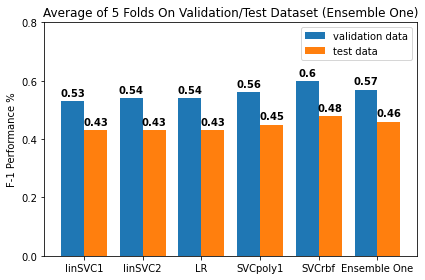

In [336]:
# F1 Performance of the clf using test data
#    linSVC1 : 0.4303
#    linSVC2 : 0.4247
#         LR : 0.4309
#   SVCpoly1 : 0.4498
#     SVCrbf : 0.4764
#       MLP2 : 0.4285
# ensemb one : 0.4511
# ensemb two : 0.4558

import matplotlib
import matplotlib.pyplot as plt
import numpy as np



labels = ['linSVC1' , 'linSVC2', 'LR', 'SVCpoly1', 'SVCrbf', 'Ensemble One']
F1_validation_data = [0.53, 0.54, 0.54, 0.56, 0.60, 0.57]
F1_test_data = [0.43, 0.43, 0.43, 0.45, 0.48, 0.46]

x = np.arange(len(labels))  # the label locations
width = 0.39  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, F1_validation_data, width, label='validation data')
rects2 = ax.bar(x + width/2, F1_test_data, width, label='test data')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F-1 Performance %')
ax.set_title('Average of 5 Folds On Validation/Test Dataset (Ensemble One)')
ax.set_yticks(np.arange(0, 1.0, 0.2))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

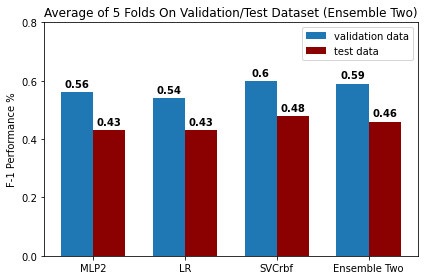

In [335]:
# F1 Performance of the clf using test data
#    linSVC1 : 0.4303
#    linSVC2 : 0.4247
#         LR : 0.4309
#   SVCpoly1 : 0.4498
#     SVCrbf : 0.4764
#       MLP2 : 0.4285
# ensemb one : 0.4511
# ensemb two : 0.4558

import matplotlib
import matplotlib.pyplot as plt
import numpy as np



labels = ['MLP2' , 'LR',  'SVCrbf', 'Ensemble Two']
F1_validation_data = [   0.56, 0.54,      0.60,           0.59]
F1_test_data = [   0.43, 0.43,      0.48,           0.46]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, F1_validation_data, width, label='validation data')
rects2 = ax.bar(x + width/2, F1_test_data, width, label='test data', color = 'darkred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F-1 Performance %')
ax.set_title('Average of 5 Folds On Validation/Test Dataset (Ensemble Two)')
ax.set_yticks(np.arange(0, 1.0, 0.2))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Ensemble Performace Confusion Matrix 

Text(0.5, 1.0, 'CM with test data on Ensemble 1')

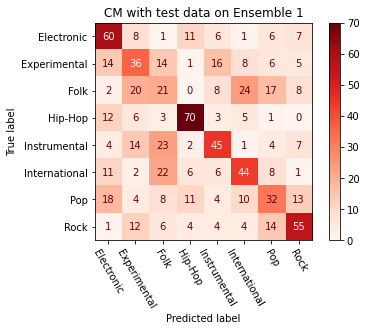

In [299]:
from sklearn.metrics import plot_confusion_matrix
display_labels = ['Electronic','Experimental','Folk','Hip-Hop','Instrumental','International','Pop','Rock']

cm2dhist = plot_confusion_matrix(eclf, x_test, y_test_true, cmap=plt.cm.Reds, display_labels = display_labels, xticks_rotation = -60)
cm2dhist.ax_.set_title('CM with test data on Ensemble 1')

Text(0.5, 1.0, 'CM with test data on Ensemble 2')

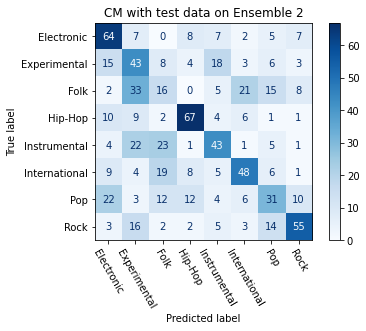

In [298]:
from sklearn.metrics import plot_confusion_matrix
display_labels = ['Electronic','Experimental','Folk','Hip-Hop','Instrumental','International','Pop','Rock']

cm2dhist = plot_confusion_matrix(eclf2, x_test, y_test_true, cmap=plt.cm.Blues, display_labels = display_labels, xticks_rotation = -60)
cm2dhist.ax_.set_title('CM with test data on Ensemble 2')

### Case Study

In [302]:

correct = list()
wrong = list()
for i in range(len(test)):
    if eclf_test_pred[i] == y_test_true[i]:
        correct.append(i)
    elif eclf_test_pred[i] != y_test_true[i]:
        wrong.append(i)

gdic={
    0: 'Electronic',
    1: 'Experimental',
    2: 'Folk',
    3: 'Hip-Hop',
    4: 'Instrumental',
    5: 'International',
    6: 'Pop',
    7: 'Rock'

}


print('correct')
for i in range(len(correct)):
    print("trackID: {} prediction: {} ({}) groundtruth: {} ({})".format(test[correct[i]], 
                                                           eclf_test_pred[correct[i]], 
                                                           gdic[eclf_test_pred[correct[i]]], 
                                                           y_test_true[correct[i]], 
                                                           gdic[y_test_true[correct[i]]]))

print('*******************')
print('wrong')
for i in range(len(wrong)):
    print("trackID: {} prediction: {} ({}) groundtruth: {} ({})".format(test[wrong[i]], 
                                                       eclf_test_pred[wrong[i]],
                                                       gdic[eclf_test_pred[wrong[i]]], 
                                                       y_test_true[wrong[i]],
                                                       gdic[y_test_true[wrong[i]]]))






uth: 5 (International)
trackID: 38820 prediction: 2 (Folk) groundtruth: 5 (International)
trackID: 38821 prediction: 4 (Instrumental) groundtruth: 5 (International)
trackID: 38822 prediction: 2 (Folk) groundtruth: 5 (International)
trackID: 38824 prediction: 2 (Folk) groundtruth: 5 (International)
trackID: 38825 prediction: 1 (Experimental) groundtruth: 5 (International)
trackID: 38826 prediction: 2 (Folk) groundtruth: 5 (International)
trackID: 38828 prediction: 6 (Pop) groundtruth: 5 (International)
trackID: 38829 prediction: 4 (Instrumental) groundtruth: 5 (International)
trackID: 38833 prediction: 2 (Folk) groundtruth: 5 (International)
trackID: 38834 prediction: 2 (Folk) groundtruth: 5 (International)
trackID: 39316 prediction: 0 (Electronic) groundtruth: 1 (Experimental)
trackID: 39317 prediction: 0 (Electronic) groundtruth: 1 (Experimental)
trackID: 39318 prediction: 7 (Rock) groundtruth: 1 (Experimental)
trackID: 39605 prediction: 3 (Hip-Hop) groundtruth: 0 (Electronic)
trackID

### Tracks per Genre

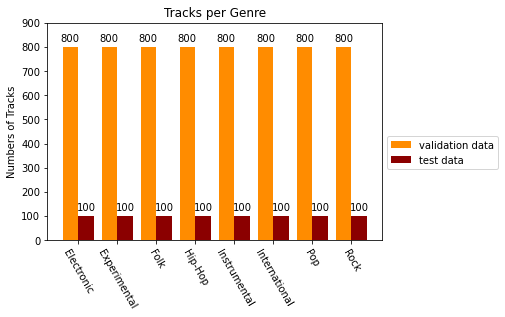

In [380]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Electronic' ,'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
test   = [ temp1_sum0, temp1_sum1, temp1_sum2, temp1_sum3, temp1_sum4, temp1_sum5, temp1_sum6, temp1_sum7]
train = [ temp2_sum0, temp2_sum1, temp2_sum2, temp2_sum3, temp2_sum4, temp2_sum5, temp2_sum6, temp2_sum7]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train, width, label='validation data', color = 'darkorange')
rects2 = ax.bar(x + width/2, test, width, label='test data', color = 'darkred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Numbers of Tracks')
ax.set_title('Tracks per Genre')
ax.set_yticks(np.arange(0, 901, 100))
ax.set_xticklabels(labels, rotation=-60)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

# fig.tight_layout()

plt.show()

## DL on raw audio

### Select small FMA

In [41]:
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [42]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))


6400 training examples, 800 validation examples, 800 testing examples


In [43]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [44]:
# Just be sure that everything is fine. Multiprocessing is tricky to debug.
print(train.to_numpy())
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape


[     2      5     10 ... 154413 154414 155066]


(2, 1321967)

In [12]:
# Keras parameters.
import os

NB_WORKER = len(os.sched_getaffinity(0))  # number of usables CPUs
params = {'use_multiprocessing': True, 'workers': NB_WORKER, 'max_queue_size': 10}

### Fully Connected NN

In [14]:
import keras
print(keras.__version__)
import utils
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
print('Dimensionality: {}'.format(loader.shape))

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(units=1000, input_shape=loader.shape))
model.add(Activation("relu"))
model.add(Dense(units=100))
model.add(Activation("relu"))
model.add(Dense(units=labels_onehot.shape[1]))
model.add(Activation("softmax"))

optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=64), train.size, epochs=2, **params)
# fit_generator(<utils.bui..., 6400, epochs=2, workers=4, use_multiprocessing=True, max_queue_size=10)
loss = model.evaluate_generator(SampleLoader(val, batch_size=64), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=64), test.size, **params)
#Y = model.predict_generator(SampleLoader(test, batch_size=64), test.size, **params);

loss

2.3.1
Dimensionality: (59953,)


/media/lucas/Data/installed/anaconda3/envs/ds/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/2
   2/6400 [..............................] - ETA: 22:11:29 - loss: 159006265972607.6875 - accuracy: 0.1328

ValueError: could not broadcast input array from shape (59929) into shape (59953)

### CNN

In [16]:
loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, subsample_length=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
#model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=10), train.size, epochs=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=10), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=10), test.size, **params)

loss

(None, 479625, 1)
(None, 936, 128)
(None, 929, 32)
(None, 225, 32)
(None, 56, 32)
(None, 1792)
(None, 100)
(None, 8)


/media/lucas/Data/installed/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 512, strides=512)`
  # This is added back by InteractiveShellApp.init_path()
/media/lucas/Data/installed/anaconda3/envs/ds/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
  28/6400 [..............................] - ETA: 1:32:59 - loss: 48574014952753264877031603044352.0000 - accuracy: 0.0964

ValueError: could not broadcast input array from shape (479434) into shape (479625)